# Multiclass Classification

In [32]:
#import dependencies
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import ClassifierChain

### Predicting the class label from many possible class labels

In [2]:
#fetch dataset, create training and test data

mnist = fetch_openml('mnist_784', as_frame=False) 
X, y = mnist.data, mnist.target
some_input = X[0] #this is a 5
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

/Users/Cheks/opt/anaconda3/envs/python/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
#train a support vector machine classifier on the first 2000 instances to save time
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) #sklearn uses the OvO strategy here (more than 2 classes)

SVC(random_state=42)

In [5]:
#what does svc predict?
svm_clf.predict([some_input]) #predicts a 5 - correct!

array(['5'], dtype=object)

In [6]:
#also check the scores using the .decision_function() method
some_digit_scores = svm_clf.decision_function([some_input])
some_digit_scores.round(2) #highest score corresponds to 5

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [7]:
#trained classifiers store the list of target classes in the classes_ attribute, ordered by value
svm_clf.classes_
#obtain the class with the highest value
class_id = some_digit_scores.argmax()
#what class?
svm_clf.classes_[class_id]

'5'

In [8]:
#force sklearn to use either OvO or OvR by creating an instance and passing a classifier into its constructor:
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [9]:
ovr_clf.predict([some_input]) #predicts 5

array(['5'], dtype='<U1')

In [10]:
#how many estimators did we make using OvR? 
len(ovr_clf.estimators_) #10, as expected

10

Scaling the inputs using StandardScaler() can improve performance.

In [3]:
#no scaling
sgd_clf = SGDClassifier(random_state=42)

In [ ]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_input]) #predicts 3

In [12]:
#accuracy of non scaled classifier
cv_accuracy_scores = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring= "accuracy") #there are roughly the same number of instances in each class so accuracy metric is fine.

In [13]:
cv_accuracy_scores #over 85.8% on all three test folds

array([0.87365, 0.85835, 0.8689 ])

In [5]:
#scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy') #mininum accuracy of 89.1% for each fold!

## Error Analysis

In [6]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

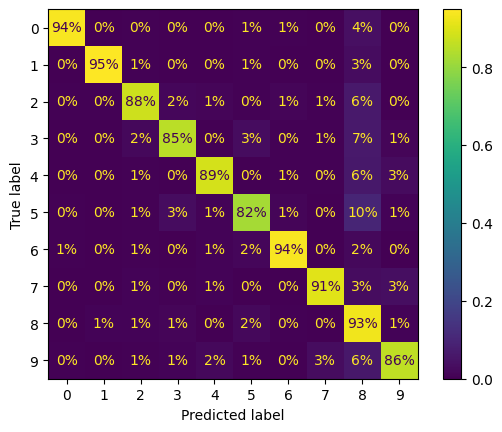

In [20]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%") #format to obtain percentages with no decimals
#setting normalise = 'true' divides the number in each cell by the total number of instances in that class. helps visualise how many errors for each class.
#5s were often misclassified as 8s. but only 2% of 8s are misclassified as 5s.


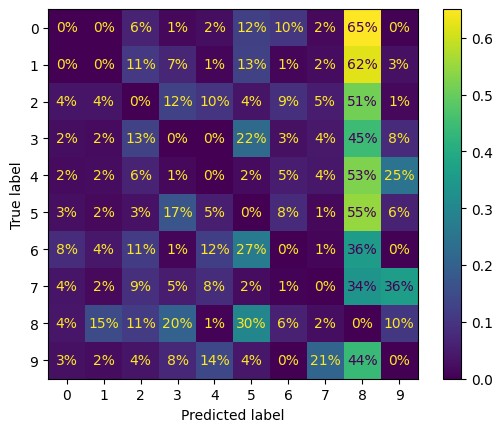

In [21]:
#you can put zero weight on the correct predictions to make errors stand out more
sample_weight = (y_train_pred != y_train) #0 when correct, 1 when incorrect
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format=".0%")
#confirms that many images are misclassified as 8s. e.g. 65% of the errors for 0s were misclassified as 8s.
#remember that this refers to the percentage of ERRORS and not of images 

Text(0.5, 1.0, 'Errors normalized by columns')

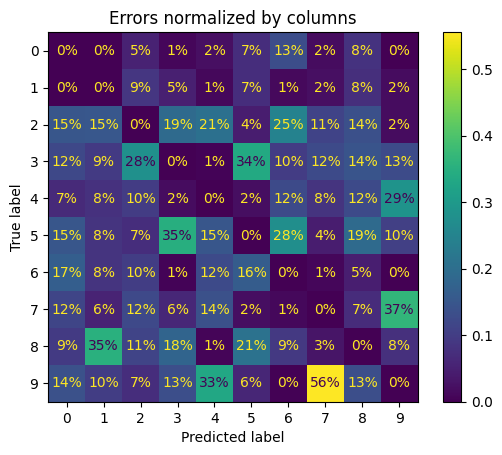

In [24]:
#normalise by column by setting normalise = 'pred'
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='pred', values_format=".0%")
#here we can see that 56% of images misclassified as 7s are actually 9s
plt.title("Errors normalized by columns")

### Interpreting the results

- Probably gather more training data for digits that look like 8s but are not so that the classifier can learn to distinguish them from real 8s.
- Or engineer new features that would help the classifier, for example writing an algorithm to count the number of closed loops
- Preprocess the images to make some patterns (such as closed loops) stand out more

### Analyzing individual errors

In [7]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


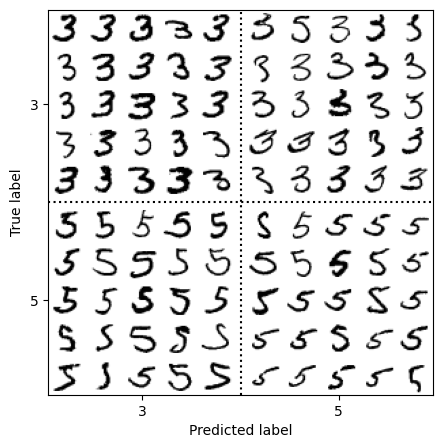

In [10]:
#plotting the confusion matrix

size = 5
pad = 0.2
plt.figure(figsize=(size, size)) #create a new figure

#for each square in the square grid we will create
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    
    #for each image index and image (indices created using enumerate)
    for idx, image_data in enumerate(images[:size*size]):

        #create x and y coordinates for each image in each cell in the matrix
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
        
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
savefig("error_analysis_digits_plot")
plt.show()

## Multilabel Classification

In [24]:
y_train_large = (y_train.astype('int') >= 7) #numbers greater than or equal to 7
y_train_odd = (y_train.astype('int8')%2 == 1)

#each instance should have multiple labels
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel #concatenate slice objects along the second axis (columns of each array)

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [25]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [26]:
knn_clf.predict([some_input])

array([[False,  True]])

### Evaluating a Multilabel Classifier

In [27]:
#avg F1 score
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [30]:
f1_score(y_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

This score assumes that all labels are equally important. Might want to give more weight to some classes especially if they are more common than others.

In this case you can set average = 'weighted' in the f1 function, which weights each label by the support.

### Chain Classifier

In [33]:
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [34]:
chain_clf.predict([some_input]) #corresponds to less than 7, odd. true since this is 5!

array([[0., 1.]])

## Multioutput Classification

In this section we build a system that removes noise from images. It takes a noisy image as an input and outputs a clean digit image. 

The output is multilabel. There is one label per pixel, and each label can have multiple values (pixel intensity ranges from 0 to 255), making this a multioutput classification system.

### Create the training and test sets

In [35]:
np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_train),784) )  #len(X_train) number of instances, 784 pixels per instance
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test),784) )  #len(X_test) number of instances, 784 pixels per instance
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test


### Visualise input data instance and output (multiple labels)

In [37]:
def show_digit(input_data):
    image = input_data.reshape(28,28)

    #use imshow to show an image based on numpy array data. binary is greyscale (black/white)
    plt.imshow(image, cmap = "binary")


    #turn off axes
    plt.axis("off")

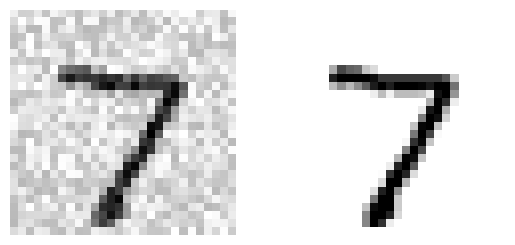

In [44]:
plt.subplot(121) ; show_digit(X_test_mod[0]) # argument (121) = (1,2,1): this is the same as create a figure with 1 row, 2 columns and place the subfigure in the 1st cell
plt.subplot(122) ; show_digit(y_test_mod[0]) #place the subfigure in the 2nd cell. the first two parameters must remain the same. 


### Train and predict using the classifier

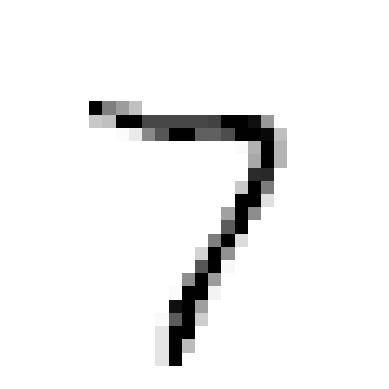

In [45]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
show_digit(clean_digit) #pretty good!